# readme 

descrip: codes to compute divergene of (1) depth-integrated velocity (volume transport) <br>

update history: <br>
v1.0 2021Oct06 <br>

extra notes: <br>
I showed two ways to compute barotropic volume convergence: 1. first compute u, v vertical integration then compute divergence; 2 first compute u, v divergence on each z level then compute vertical integration. I showed both methods in this notebook. Be aware that it is memory consuming to compute divergence on global HR POP grids. <br>

reference: I follow Steve Yeager's code (https://github.com/sgyeager/POP_MOC/blob/main/pop_moc_0p1deg.py) and NCAR pop-tool example (https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb) to compute divergence. Steve's MOC codes also have heat transport calculations. <br>

Pangeo example (https://github.com/pangeo-data/pangeo-ocean-examples/blob/master/cesm-pop-highres-ocean.ipynb) shows how to compute wind stress curl <br>

possible next step: compute denpth-integrated velocity*in-situ density (mass transport) <br>

# import modules

In [2]:
import xarray as xr               #netcdf multidim reading/writing/manipulation
import glob                       #globbing
import numpy as np                #numerics
import os                 #operating system commands
import subprocess
import time as timer
import pop_tools
import sys
import util
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot

In [3]:
in_file = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
           'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1850-01.nc')

In [4]:
%%time
# copied from Steve Yegare's code (https://github.com/sgyeager/POP_MOC/blob/main/pop_moc_0p1deg.py) and comments a few lines
# Open a POP history file requiring MOC
ds = xr.open_dataset(in_file)
pd     = ds['PD']
pd=pd.drop(['ULAT','ULONG'])            # this is a python bug that we are correcting
temp   = ds['TEMP']
temp=temp.drop(['ULAT','ULONG'])
# salt   = ds['SALT']
# salt=salt.drop(['ULAT','ULONG'])
# u_e   = ds['UVEL']/100
# u_e=u_e.drop(['TLAT','TLONG'])
# u_e.attrs['units']='m/s'
# v_e   = ds['VVEL']/100
# v_e=v_e.drop(['TLAT','TLONG'])
# v_e.attrs['units']='m/s'
# w_e   = ds['WVEL']/100
# w_e=w_e.drop(['ULAT','ULONG'])
# w_e.attrs['units']='m/s'
ulat   = ds['ULAT']
ulon   = ds['ULONG']
tlat   = ds['TLAT']
tlon   = ds['TLONG']
kmt  = ds['KMT']
kmt.values[np.isnan(kmt.values)]=0	# get rid of _FillValues
kmu  = ds['KMU']
kmu.values[np.isnan(kmu.values)]=0	# get rid of _FillValues
dxu    = ds['DXU']/100
dxu.attrs['units']='m'
dyu    = ds['DYU']/100
dyu.attrs['units']='m'
rmask  = ds['REGION_MASK']
tarea  = ds['TAREA']/100/100
tarea.attrs['units']='m^2'
uarea  = ds['UAREA']/100/100
uarea.attrs['units']='m^2'
time   = ds['time']
time.encoding['_FillValue']=None    
z_t   = ds['z_t']/100
z_t.attrs['units']='m'
z_w   = ds['z_w']/100
z_w.attrs['units']='m'
z_w_bot   = ds['z_w_bot']/100
z_w_bot.attrs['units']='m'
dz   = ds['dz']/100
dz.attrs['units']='m'
dzw   = ds['dzw']/100
dzw.attrs['units']='m'
hu   = ds['HU']/100
hu.attrs['units']='m'
ht   = ds['HT']/100
ht.attrs['units']='m'
dims = np.shape(temp)
nt = dims[0]
nz = dims[1]
ny = dims[2]
nx = dims[3]
km = int(np.max(kmt).values)
mval=pd.encoding['_FillValue']

# Create a k-index array for masking purposes
kji = np.indices((nz,ny,nx))
kindices = kji[0,:,:,:] + 1

# Define top/bottom depths of POP T-grid
z_bot=z_w.values
z_bot=z_w.values+dz.values
z_top=z_w.values

# Compute PBC from grid info:
dzt = util.pbc_dzt(dz,kmt,ht,z_w_bot,mval)

# Regrid PBC thicknesses to U-grid
tmp=dzt
tmpe=tmp.roll(nlon=-1,roll_coords=False)        # wraparound shift to west, without changing coords
tmpn=tmp.shift(nlat=-1)                         # shift to south, without changing coords
tmpne=tmpn.roll(nlon=-1,roll_coords=False)      # wraparound shift to west, without changing coords
tmpall=xr.concat([tmp,tmpe,tmpn,tmpne],dim='dummy')
dzu=tmpall.min('dummy')
dzu.attrs['units'] = 'm'
del tmp,tmpe,tmpn,tmpne,tmpall

ds

CPU times: user 15.6 s, sys: 12.1 s, total: 27.8 s
Wall time: 27.9 s


In [6]:
# add PBC corrected DZT and DZU, copied from 
# https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb
ds["DZT"] = dzt*100
ds["DZU"] = dzu*100
ds["cell_volume_t"] = ds.DZT * ds.DXT * ds.DYT
ds["cell_volume_u"] = ds.DZU * ds.DXT * ds.DYT
ds

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * time                (time) object 1850-02-01 00:00:00
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 ...
    ULAT                (nlat, nlon) float64 ...
    TLONG               (nlat, nlon) float64 ...
    TLAT                (nlat, nlon) float64 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/98)
    time_bound          (time, d2) object 1850-01-01 00:32:23.999997 1850-02-...
    dz                  (z_t) float32 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    dzw                 (z_w) float32 500.0 1e+03 1e+03 ... 2.5e+04 2.5e+04
    KMT                 (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    KMU                 (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    REGION_MASK         (nlat, nlon) float64 ...
    ...                  ...
    XBLT                (time, nlat, nlon) float32 ...
    TBLT                (time, nlat, nlon) float32 ...
    DZT                 (z_t, nlat, nlon) float64 9.969e+38 ... 9.969e+38
    DZU                 (z_t, nlat, nlon) float64 9.969e+38 ... 9.969e+38
    cell_volume_t       (z_t, nlat, nlon) float64 9.969e+38 ... 9.969e+38
    cell_volume_u       (z_t, nlat, nlon) float64 9.969e+38 ... 9.969e+38
Attributes:
    title:           B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2019-10-29 at 17:54:15.4
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    19331
    tavg_sum:        2676600.0
    tavg_sum_qflux:  2676600.0

In [7]:
# copied from https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb

# --- minimul xgcm version ---
# grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds)
# ds_ren
# ----------------------------

# --- full xgcm version ---
# pop_tools should handle this bit in the future
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],  # areas, technically not needed
}


# xgcm metrics
gridm, xdsm = pop_tools.to_xgcm_grid_dataset(ds, metrics=metrics)
xdsm

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlat_t: 2400, nlat_u: 2400, nlon: 3600, nlon_t: 3600, nlon_u: 3600, time: 1, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * time                (time) object 1850-02-01 00:00:00
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    ...                  ...
    TLONG               (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    TLAT                (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 ... 3596 3597 3598 3599 3600
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 ... 2396 2397 2398 2399 2400
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/98)
    time_bound          (time, d2) object 1850-01-01 00:32:23.999997 1850-02-...
    dz                  (z_t) float32 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    dzw                 (z_w_top) float32 500.0 1e+03 1e+03 ... 2.5e+04 2.5e+04
    KMT                 (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    KMU                 (nlat_u, nlon_u) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    REGION_MASK         (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    ...                  ...
    XBLT                (time, nlat_t, nlon_t) float32 -1.0 -1.0 ... -1.0 -1.0
    TBLT                (time, nlat_t, nlon_t) float32 -1.0 -1.0 ... -1.0 -1.0
    DZT                 (z_t, nlat_t, nlon_t) float64 9.969e+38 ... 9.969e+38
    DZU                 (z_t, nlat_u, nlon_u) float64 9.969e+38 ... 9.969e+38
    cell_volume_t       (z_t, nlat, nlon) float64 9.969e+38 ... 9.969e+38
    cell_volume_u       (z_t, nlat, nlon) float64 9.969e+38 ... 9.969e+38
Attributes:
    title:           B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2019-10-29 at 17:54:15.4
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    19331
    tavg_sum:        2676600.0
    tavg_sum_qflux:  2676600.0

In [ ]:
### first compute div for each z_t level then sum over z_t dim

In [42]:
u_sum_z = xdsm.UVEL.isel(time=0).weighted(xdsm.DZU).sum('z_t')
v_sum_z = xdsm.VVEL.isel(time=0).weighted(xdsm.DZU).sum('z_t')
u_sum_z

<xarray.DataArray 'UVEL' (nlat_u: 2400, nlon_u: 3600)>
array([[-6.18091018e+40, -6.18091018e+40, -6.18091018e+40, ...,
        -6.18091018e+40, -6.18091018e+40, -6.18091018e+40],
       [-6.18091018e+40, -6.18091018e+40, -6.18091018e+40, ...,
        -6.18091018e+40, -6.18091018e+40, -6.18091018e+40],
       [-6.18091018e+40, -6.18091018e+40, -6.18091018e+40, ...,
        -6.18091018e+40, -6.18091018e+40, -6.18091018e+40],
       ...,
       [-6.18091018e+40, -6.18091018e+40, -6.18091018e+40, ...,
        -6.18091018e+40, -6.18091018e+40, -6.18091018e+40],
       [-6.18091018e+40, -6.18091018e+40, -6.18091018e+40, ...,
        -6.18091018e+40, -6.18091018e+40, -6.18091018e+40],
       [-6.18091018e+40, -6.18091018e+40, -6.18091018e+40, ...,
        -6.18091018e+40, -6.18091018e+40, -6.18091018e+40]])
Coordinates:
    time     object 1850-02-01 00:00:00
    ULONG    (nlat_u, nlon_u) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ULAT     (nlat_u, nlon_u) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 ... 3594 3595 3596 3597 3598 3599 3600
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 ... 2394 2395 2396 2397 2398 2399 2400

In [54]:
# using xgcm
def div_4pt_xgcm(U, V):  # Basic stencil operator for B-grid divergence
    """
    POP stencil operator for divergence
    using xgcm
    """
    U_at_lat_t = gridm.interp(U, axis="Y", boundary="extend")  # array - array.roll becomes interp
    # -> this incoorporates the * 0.5
    dUdx = gridm.diff(U_at_lat_t, axis="X", boundary="extend")  # - becomes diff
    V_at_lon_t = gridm.interp(V, axis="X", boundary="extend")
    dVdy = gridm.diff(V_at_lon_t, axis="Y", boundary="extend")
    div_4pt = dUdx + dVdy
    return div_4pt


def divh_xgcm_DL(U, V, ds_grid):  # Divergence of horizontal velocity. Result on T-grid
    """
    calulate divergence with xgcm
    2021Mar08 edited by DL: remove ds_grid.DZU and ds_grid.DZT, Qiuying said DZT and DZU are the same
    """
    changed_U = U * ds_grid.DYU
    changed_V = V * ds_grid.DXU
    divh = div_4pt_xgcm(changed_U, changed_V) / ds_grid.TAREA
    return divh

In [55]:
vel_div = divh_xgcm_DL(u_sum_z, v_sum_z, xdsm) # mass (m) flux (f)
vel_div 

<xarray.DataArray (nlat_t: 2400, nlon_t: 3600)>
array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
Coordinates:
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
    TLONG    (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    TLAT     (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0

In [1]:
# plot barotropic volume transport for global and north atlantic
fig, axs = plt.subplots(1,2,figsize=(10,2))
vel_div.plot(ax=axs[0], robust=True)
vel_div.isel(nlon_t=slice(0,1000), nlat_t=slice(1300,1800)).plot(ax=axs[1], robust=True)

NameError: name 'plt' is not defined

### first compute div for each z_t level then sum over z_t dim

In [ ]:
# copied from https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb
def div_stencil(U, V, grid):  # Basic stencil operator for B-grid divergence
    """
    stencil operator for divergence
    using xgcm.metrics on pop
    """
    U = grid.interp(U, axis="Y", boundary="extend")
    V = grid.interp(V, axis="X", boundary="extend")
    dUdx = grid.diff(U, axis="X", boundary="extend")
    dVdy = grid.diff(V, axis="Y", boundary="extend")
    div_4pt = dUdx + dVdy
    return div_4pt


def x_divh(U, V, grid, boundary=None):
    """
    horizontal divergence
    with xgcm.get_metrics
    """
    dy = grid.get_metric(U, "Y")
    dx = grid.get_metric(V, "X")
    dz = grid.get_metric(U, "Z")
    UT = U * dy * dz
    VT = V * dx * dz
    div = div_stencil(UT, VT, grid)
    volume = grid.get_metric(div, "XYZ")
    div = div / volume

    return div

In [9]:
div_xgcm_m = x_divh(xdsm.UVEL, xdsm.VVEL, gridm)
div_xgcm_m

<xarray.DataArray (time: 1, z_t: 62, nlat_t: 2400, nlon_t: 3600)>
array([[[[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]],

        [[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]],

        [[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
...
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]],

        [[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]],

        [[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]]]])
Coordinates:
  * time     (time) object 1850-02-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03

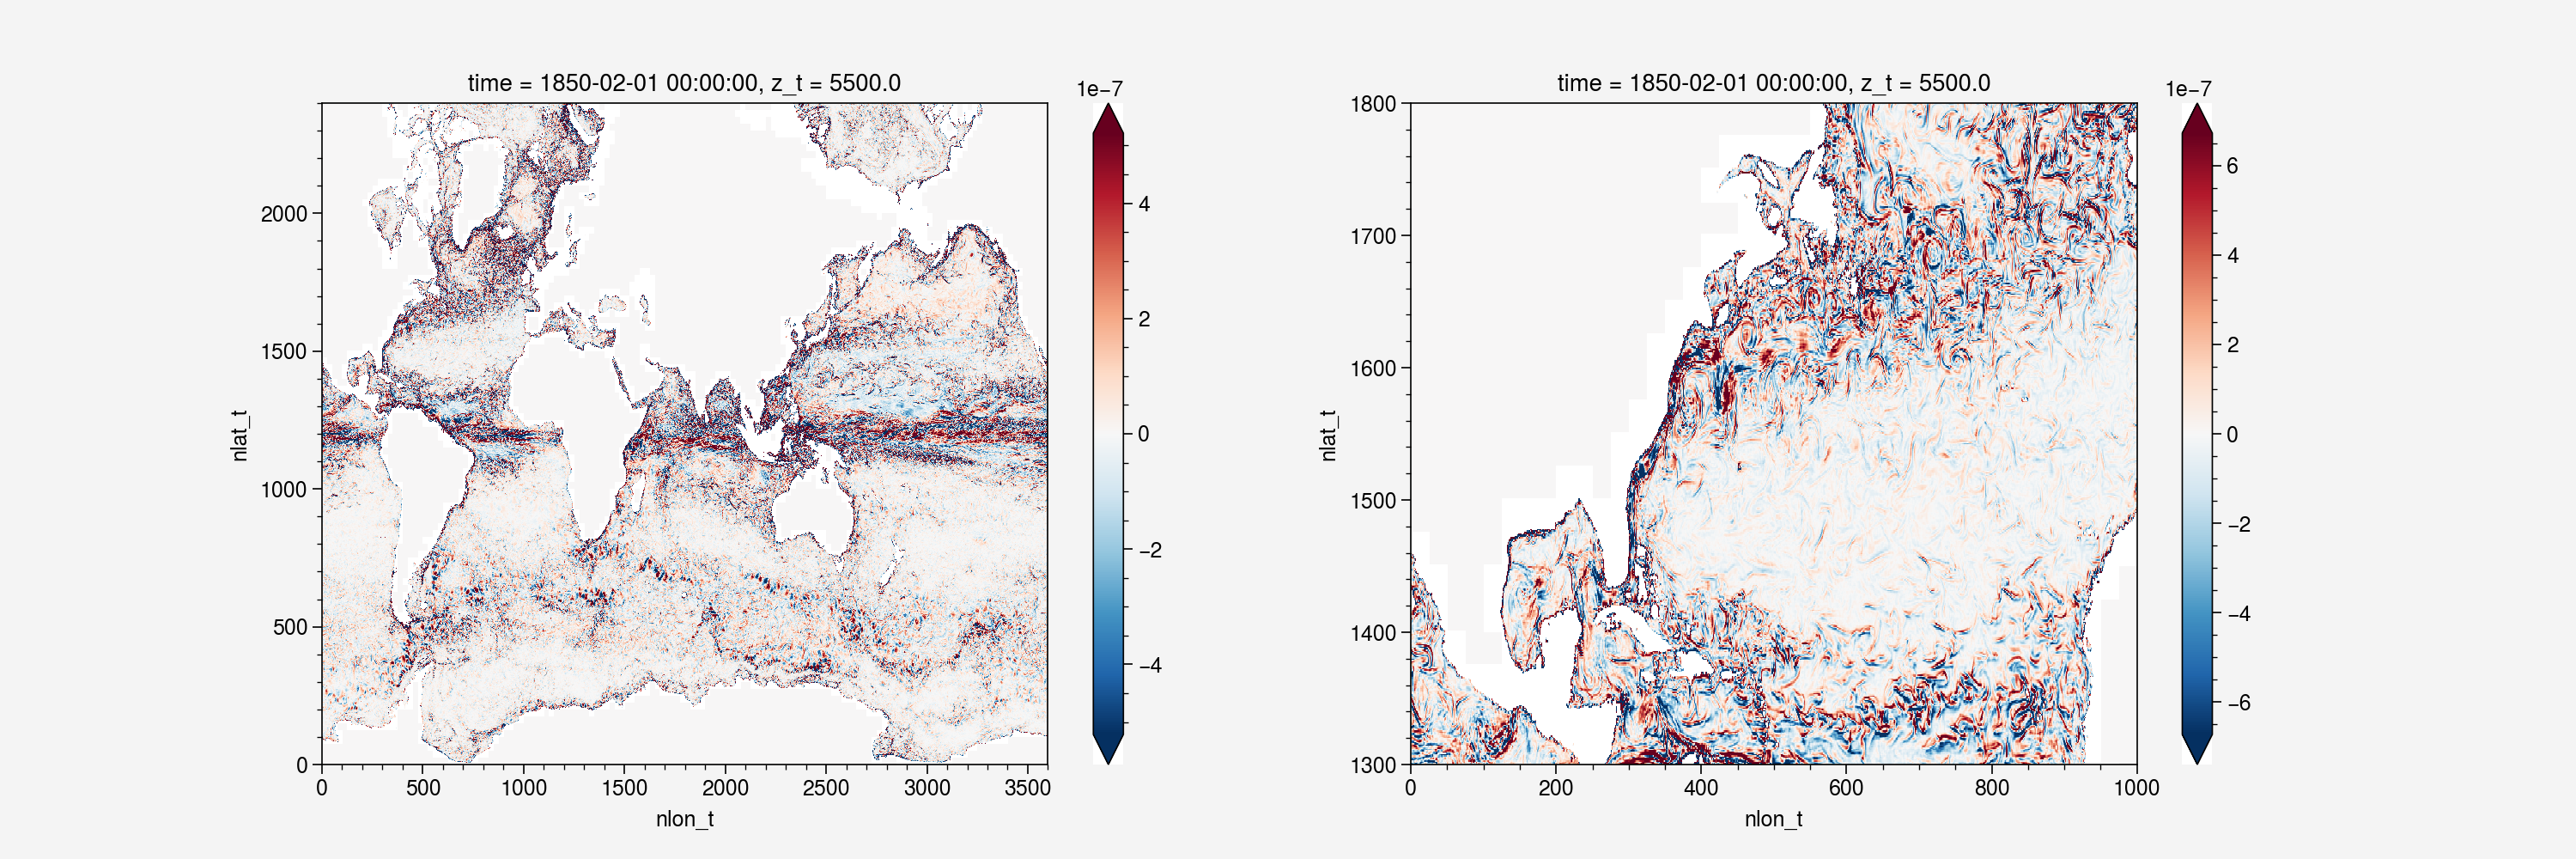

In [17]:
# surface vel convergence for global and north atlantic
fig, axs = plt.subplots(1,2,figsize=(15,5))
div_xgcm_m.isel(z_t=5, time=0).plot(ax=axs[0], robust=True)
div_xgcm_m.isel(z_t=5, time=0, nlon_t=slice(0,1000), nlat_t=slice(1300,1800)).plot(ax=axs[1], robust=True)

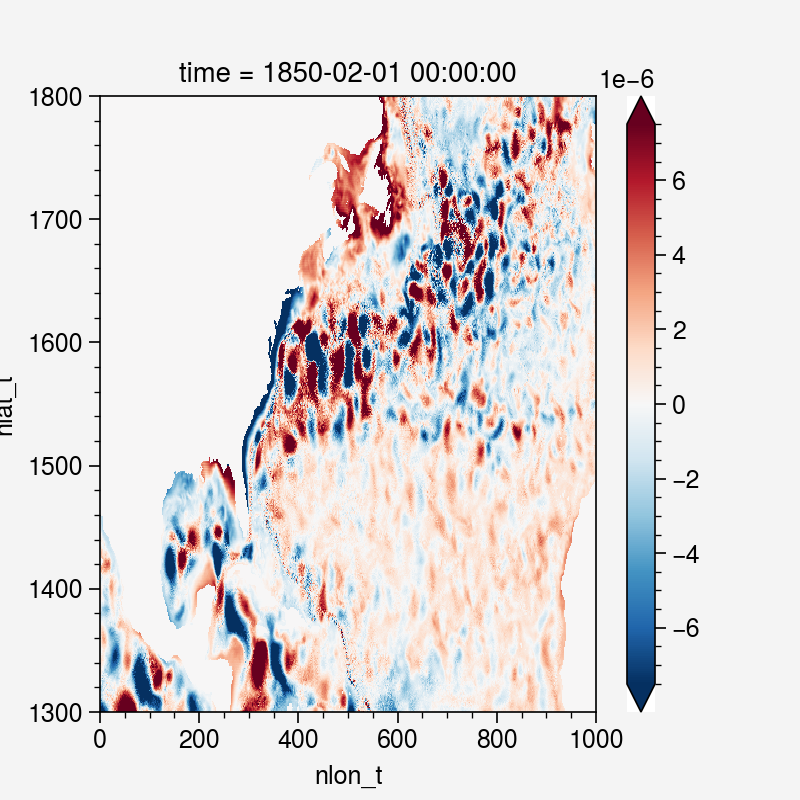

In [36]:
# div sum over z_t dim for north atlantic
div_xgcm_m.weighted(xdsm.DZT).sum('z_t').isel(time=0, nlon_t=slice(0,1000), nlat_t=slice(1300,1800)).plot(robust=True)

In [37]:
# estimate monthly SSH change rate (cm/s) due to barotropic volume transport 
7e-6 * 30 * 86400

18.144000000000002

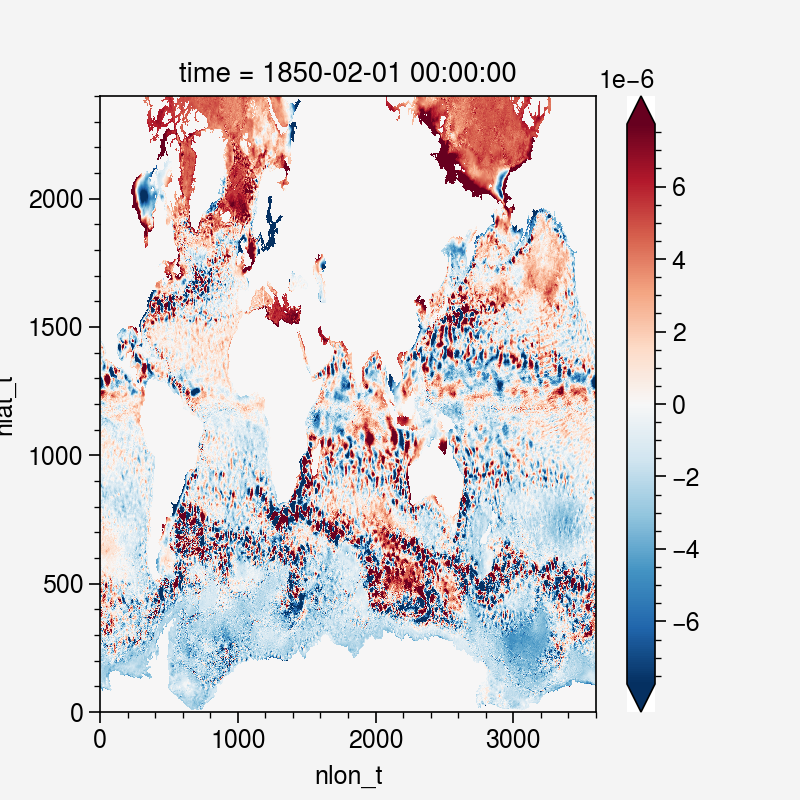

In [38]:
# vertically integrated vel convergence over global ocean
div_xgcm_m.weighted(xdsm.DZT).sum('z_t').isel(time=0).plot(robust=True)